In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st

import random
from scipy import stats
from matplotlib import gridspec

In [2]:
Nexp = 100# Number of experiment
train_N = 200# Number of trial

class Train:
    def __init__(self):
        self.N = train_N
        self.actions = np.zeros(self.N)# 0 or1
        self.D = np.zeros(self.N+1)# d(Ht)
        self.D_est = np.zeros(self.N+1)# d(Ht+1)
        self.H = np.zeros(self.N+1)# Homeostasis
        self.H[0] = 0
        self.H_ast = 50# setpoint
        self.P_1 = np.zeros(self.N)# P(intake)

        self.K = np.zeros(self.N)# K
        self.Q = np.zeros((2, self.N+1))# Q value
        
        self.R = np.zeros(self.N)# reward
        
        ########## parameter ###########################
        
        self.alpha = 0.05# learning rate
        self.beta = 1# temperature 大きくすると不確実が減る
        self.tau = 100
        self.mouth = 1
        
        self.m = 3
        self.n = 4
        
        ##############################################
        
    def softmax(self, a):#修正済み
        self.a = a
        sigma = np.sum(np.exp(self.Q[:, self.a]/self.beta))
        vals = []
        for i in range(2):
            softmax = np.exp(self.Q[i, self.a]/self.beta)/sigma
            vals.append(softmax)
            if i == 1:
                self.P_1[self.a] = softmax
            
        dice = random.random()
        if dice <= vals[0]:
            self.actions[self.a] = 0
        elif vals[0] < dice:
            self.actions[self.a] = 1

            
    def get_intake(self, a):
        self.a = a
        if self.actions[self.a] == 1:
            self.K[self.a] = self.mouth
            
    def get_drive(self, a):
        self.a = a
        self.D[self.a] =  (abs(self.H_ast - self.H[self.a])**self.n)**(1/self.m)
        if self.actions[self.a] == 1:# drink
            self.D_est[self.a] = (abs(self.H_ast - (1 - 1/self.tau) * self.H[self.a] - self.K[self.a])**self.n)**(1/self.m)
        else:
            self.D_est[self.a] = (abs(self.H_ast - (1 - 1/self.tau) * self.H[self.a])**self.n)**(1/self.m)

    def get_reward(self, a):
        self.a = a
        if self.H[self.a] < 50 :
            self.R[self.a] = self.D[self.a] - self.D_est[self.a]
        else:
            self.R[self.a] = self.D[self.a] - self.D_est[self.a]
    
    def update_H(self, a):
        self.a = a
        #self.H[self.a+1] = self.H[self.a] + self.K[self.a]
        self.H[self.a+1] = (1 - 1/self.tau) * self.H[self.a] + self.K[self.a]
            
    def update_Q(self, a):
        self.a = a
        if self.actions[self.a] == 0:
            self.Q[0][self.a+1] = self.Q[0][self.a] + self.alpha*(self.R[self.a]
                                                                  - self.Q[0][self.a])
            self.Q[1][self.a+1] = self.Q[1][self.a]
            
        elif self.actions[self.a] == 1:
            self.Q[0][self.a+1] = self.Q[0][self.a]
            self.Q[1][self.a+1] = self.Q[1][self.a] + self.alpha*(self.R[self.a]
                                                                  - self.Q[1][self.a])


#============================

num_l = list(range(train_N+1))
Nexp_l = list(range(Nexp))

# DataArrayの作成
#da = xr.DataArray(np.zeros((Nexp, 6, train_N+1)), [('Nexp', Nexp_l), ('variable', ['H', 'Q0', 'Q1', 'P', 'A', 'R']), ('train_N', num_l)])

a_H = np.zeros(Nexp * (train_N+1))
a_Q0 = np.zeros(Nexp * (train_N+1))
a_Q1 = np.zeros(Nexp * (train_N+1))


a_P_1 = np.zeros(Nexp * (train_N+1))
a_actions = np.zeros(Nexp * (train_N+1))
a_R = np.zeros(Nexp * (train_N+1))



class_l = []

#To make list of Classes
for i in range(Nexp):
    class_l.append(None)


#main
for j in range(Nexp):
    class_l[j] = Train()    
    for i in range(train_N):
        class_l[j].softmax(i)
        class_l[j].get_intake(i)
        class_l[j].get_drive(i)
        class_l[j].get_reward(i)
        class_l[j].update_Q(i)
        class_l[j].update_H(i)
        
    
    #長さが1つ小さい変数は前詰めで、最後の変数を0のままにする。
    
    a_H[(train_N+1)*j : (train_N+1)*(j+1)] = class_l[j].H
    a_Q0[(train_N+1)*j : (train_N+1)*(j+1)] = class_l[j].Q[0]
    a_Q1[(train_N+1)*j : (train_N+1)*(j+1)] = class_l[j].Q[1]
    a_P_1[(train_N+1)*j : (train_N+1)*(j+1)] = np.append(class_l[j].P_1, np.nan)
    a_actions[(train_N+1)*j : (train_N+1)*(j+1)] = np.append(class_l[j].actions, np.nan)
    a_R[(train_N+1)*j : (train_N+1)*(j+1)] = np.append(class_l[j].R, np.nan)

                   
df = pd.DataFrame(data=list(range((train_N+1))) * Nexp, columns=['trial'])
df['H'] = a_H
df['Q0'] = a_Q0
df['Q1'] = a_Q1
df['P'] = a_P_1
df['A'] = a_actions
df['R'] = a_R


In [3]:
fs = 20

/Users/yukiuchida/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/yukiuchida/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


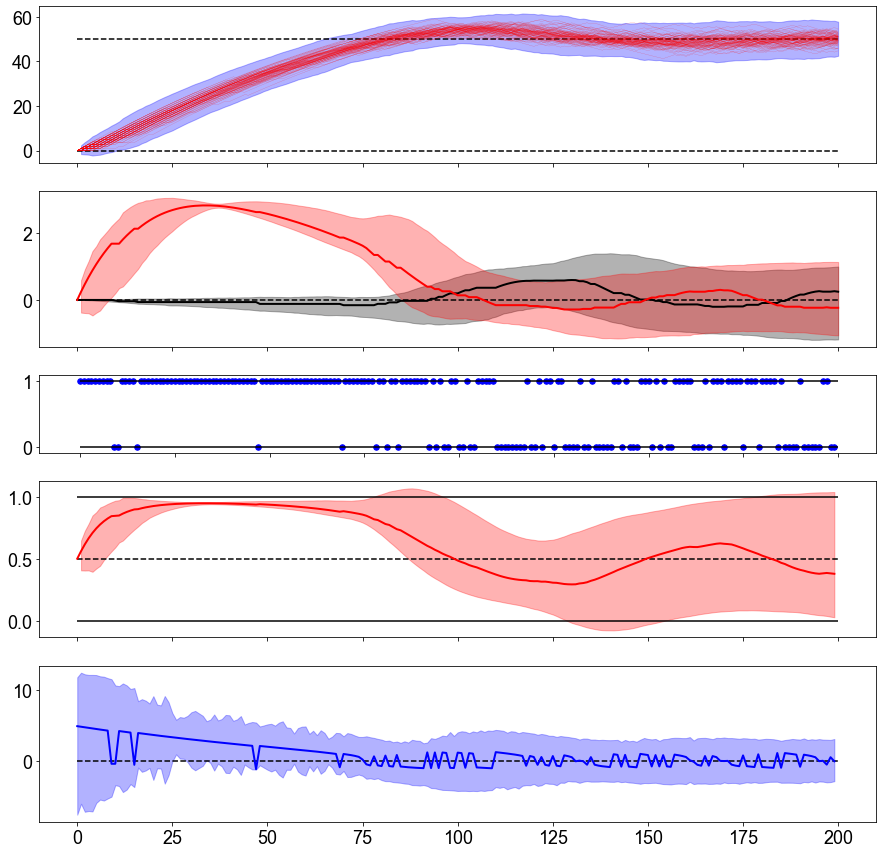

In [4]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(15,15))


spec = gridspec.GridSpec(ncols=1, nrows=5, height_ratios=[2,2,1,2,2])


ax_l = []
ax_l.append(fig.add_subplot(spec[0]))
ax_l.append(fig.add_subplot(spec[1]))
ax_l.append(fig.add_subplot(spec[2]))
ax_l.append(fig.add_subplot(spec[3]))
ax_l.append(fig.add_subplot(spec[4]))

CL = 0.95# Confidencial Level for Figures
Df = Nexp-1# degree of freedom for Figures

mean = [] #mean at t
STD = []
#SE = []# Standard Error for Figures
CI = np.zeros((5, train_N+1, 2)) #confidence interval at t


for j, h in zip(['H','Q0','Q1','P','R'], list(range(5))):
    for i in range(train_N+1):
        mean.append(sum(df.loc[df['trial']==i][j])/Nexp)
        #SE.append(stats.sem(df.loc[df['trial']==i][j]))
        #CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = SE[-1])[0]
        #CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = SE[-1])[1]
        STD.append(st.stdev(df.loc[df['trial']==i][j]))
        CI[h][i][0] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[0]
        CI[h][i][1] = stats.t.interval(alpha = CL, df = Df, loc = mean[-1], scale = 2*STD[-1])[1]
        
         
length_l, length_s = train_N+1, train_N


ax_l[0].hlines(50, 0, train_N, linestyle="dashed")
ax_l[0].hlines(0, 0, train_N, linestyle="dashed")
#ax_l[0].plot(df['H'][:length_l], linewidth=2, color='blue')
ax_l[0].fill_between(df.index[:length_l], CI[0, :, 0], CI[0, :, 1], color='blue', alpha=.3) #confidence interval curves.
ax_l[0].tick_params(labelbottom=False)


# 今回のコードのメイン部分（信頼区間の実装の確認のため、一つずつプロットする。）
for i in range(Nexp):
    conf = df['H'][i*(train_N+1):i*(train_N+1)+length_l]
    ax_l[0].plot(list(range(train_N+1)), conf, linewidth=0.1, color='red')


ax_l[1].hlines(0, 0, train_N, linestyle="dashed")
ax_l[1].plot(df['Q0'][:length_l], linewidth=2, color='black')
ax_l[1].fill_between(df.index[:length_l], CI[1, :, 0], CI[1, :, 1], color='black', alpha=.3) #confidence interval curves.
ax_l[1].plot(df['Q1'][:length_l], linewidth=2, color='red')
ax_l[1].fill_between(df.index[:length_l], CI[2, :, 0], CI[2, :, 1], color='red', alpha=.3) #confidence interval curves.
ax_l[1].tick_params(labelbottom=False)


ax_l[2].hlines(1, 0, train_N)
ax_l[2].hlines(0, 0, train_N)
ax_l[2].scatter(list(range(length_s)), df['A'][:length_s], s=30, c='blue')
ax_l[2].tick_params(labelbottom=False)


ax_l[3].hlines(0, 0, train_N)
ax_l[3].hlines(0.5, 0, train_N,  linestyle="dashed")
ax_l[3].hlines(1, 0, train_N)
ax_l[3].plot(df['P'][:length_s], linewidth=2, color='red')
ax_l[3].fill_between(df.index[:length_s], CI[3, :, 0][:length_s], CI[3, :, 1][:length_s], color='red', alpha=.3) #confidence interval curves.
ax_l[3].tick_params(labelbottom=False)


ax_l[4].hlines(0, 0, train_N, linestyle="dashed")
ax_l[4].plot(df['R'][:length_s], linewidth=2, color='blue')
ax_l[4].fill_between(df.index[:length_s], CI[4, :, 0][:length_s], CI[4, :, 1][:length_s], color='blue', alpha=.3) #confidence interval curves.
#ax_l[4].xticks(x, list(range(length_s)), fontsize=fs, fontname='Arial')

